## Introduction to Julia by Dr. Mohammad Masiur Rahaman (masiurr@iitbbs.ac.in)

## Julia is fast

Benchmark the **sum()** and compare against other popular languages.

Consider the **sum** function **sum(a)** which computes   

 $\text{sum}(a) = \Sigma_{i=1}^n a_i$

where $n$ is the length of $a$

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform in [0,1]
sum(a)

5.000300805748647e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

In [2]:
@time sum(a)

  0.004005 seconds (1 allocation: 16 bytes)


5.000300805748647e6

The @time macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a BenchmarkTools.jl package to make benchmarking easy and accurate:

## Use BenchmarkTools for comparison

In [3]:
import Pkg; Pkg.add("BenchmarkTools")

   Resolving package versions...
  No Changes to `C:\Users\amiya\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\amiya\.julia\environments\v1.11\Manifest.toml`


In [4]:
using BenchmarkTools

### 1. The C language

C is often considered the golden standerd: difficult on the human, nice for the machine.
Getting within  a factor of 2 of C is often satisfying. Nontheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read her cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the """ warp a multiline string.

In [5]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [6]:
c_sum(a)

5.000300805749172e6

In [7]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbol

true

In [8]:
c_sum(a) - sum(a)

5.252659320831299e-7

We can now benchmark the C code directly from Julia:

In [9]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 346 samples with 1 evaluation per sample.
 Range (min … max):  12.070 ms … 17.583 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     14.610 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   14.356 ms ±  1.008 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                 ▃▃█▄█▂▄▄ ▃                    
  █▅▆▆▅▃▄▃▄▄▂▄▃▂▁▃▁▁▁▁▁▁▂▁▁▂▁▄▄▆▇████████▇██▅█▄▄▅▄▁▁▂▃▁▁▂▁▁▃▂ ▄
  12.1 ms         Histogram: frequency by time        16.4 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [10]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 12.07 msec


In [11]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 12.07

In [12]:
using Plots
gr()

Plots.GRBackend()

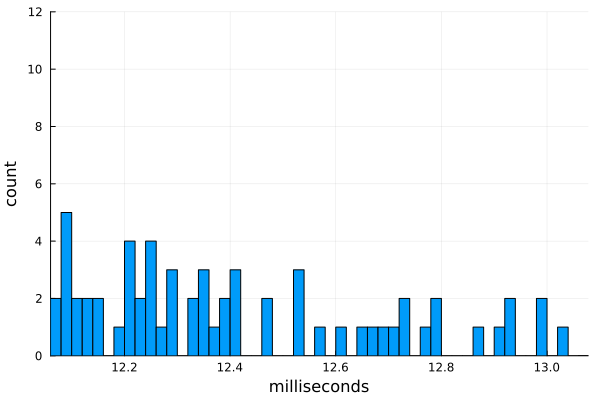

In [13]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

### 2. C with -ffast-math
If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD 
(single instruction, multiple data) instructions.

In [14]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [15]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 664 samples with 1 evaluation per sample.
 Range (min … max):  6.207 ms … 12.232 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.524 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.522 ms ±  1.379 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▃▁▁                               ▁▂▂▃▁▃▂▁▁▁               
  █████▇▇█▄▄▆▄▄▄▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▄▁▅▄▇█████████████▇▇▆▇▄▅▇▅▅▇▄ ▇
  6.21 ms      Histogram: log(frequency) by time       10 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [16]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 2 entries:
  "C"             => 12.07
  "C -ffast-math" => 6.2075

### 3. Python's built in sum

The PyCall package provides a Julia interface to Python:

In [17]:
# import Pkg; Pkg.add("PyCall")

In [18]:
using PyCall

In [19]:
# get the Python built-in "sum" function:

pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [20]:
pysum(a) ≈ sum(a)

true

In [21]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 7 samples with 1 evaluation per sample.
 Range (min … max):  736.089 ms … 860.106 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     748.459 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   775.624 ms ±  47.601 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ██ █  █                █               █                    █  
  ██▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  736 ms           Histogram: frequency by time          860 ms <

 Memory estimate: 208 bytes, allocs estimate: 8.

In [22]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 12.07
  "Python built-in" => 736.089
  "C -ffast-math"   => 6.2075

### 4. Python: numpy
Takes advantage of hardware "SIMD", but only works when it works.

**numpy** is an optimized C library, callable from Python. It may be installed within Julia as follows:

In [23]:
# import Pkg; Pkg.add("Conda")
using Conda

In [24]:
numpy_sum = pyimport("numpy")["sum"]
a̅ = PyObject(a)

py_numpy_bench = @benchmark $numpy_sum($a̅)

BenchmarkTools.Trial: 596 samples with 1 evaluation per sample.
 Range (min … max):  7.108 ms … 16.007 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.969 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.356 ms ±  1.300 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂█                                                          
  ██▅▅▄▄▃▃▃▃▃▃▂▃▄▄▆▄▄▃▃▃▂▂▃▂▂▁▂▂▁▃▃▃▃▃▄▄▃▃▂▃▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▂ ▃
  7.11 ms        Histogram: frequency by time        11.6 ms <

 Memory estimate: 32 bytes, allocs estimate: 2.

In [25]:
numpy_sum(a)

5.000300805748647e6

In [26]:
numpy_sum(a) ≈ sum(a)

true

In [27]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 12.07
  "Python numpy"    => 7.1077
  "Python built-in" => 736.089
  "C -ffast-math"   => 6.2075

### 5. Python, hand-written

In [28]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x000002342E429300>

In [29]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 6 samples with 1 evaluation per sample.
 Range (min … max):  919.366 ms … 971.452 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     945.335 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   945.261 ms ±  23.526 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █ █             █                          █              █ █  
  █▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█ ▁
  919 ms           Histogram: frequency by time          971 ms <

 Memory estimate: 208 bytes, allocs estimate: 8.

In [30]:
sum_py(a)

5.000300805749172e6

In [31]:
sum_py(a) ≈ sum(a)

true

In [32]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 12.07
  "Python numpy"        => 7.1077
  "Python hand-written" => 919.366
  "Python built-in"     => 736.089
  "C -ffast-math"       => 6.2075

### 6. Julia (built-in)
Written directly in Julia, not in C!

In [33]:
@which sum(a)

sum(a::AbstractArray; dims, kw...)
     @ Base reducedim.jl:982

In [34]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1045 samples with 1 evaluation per sample.
 Range (min … max):  3.896 ms … 9.428 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.987 ms             ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.759 ms ± 1.232 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▅▂▁                                ▁  ▁▁▁                 
  ██████████▇█▆▇▆▆▅▆▆▇▆▇▅▅▅▁▅▁▅▄▅▄▆▅██████████▆▆▆▇▆▇▆▆▁▅▅▅▅ ▇
  3.9 ms      Histogram: log(frequency) by time      7.9 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [35]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 12.07
  "Python numpy"        => 7.1077
  "Python hand-written" => 919.366
  "Python built-in"     => 736.089
  "Julia built-in"      => 3.8963
  "C -ffast-math"       => 6.2075

### 7. Julia (hand-written)

In [36]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [37]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 368 samples with 1 evaluation per sample.
 Range (min … max):  12.133 ms … 18.041 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.953 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   13.535 ms ±  1.109 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▁▁██▃                                                 
  ██▄▇▇▅▆█████▆▇▂▃▂▃▃▃▃▁▂▂▂▁▁▃▄▄▅▆█▆▆▃▆▆▆▆▅▃▅▂▄▃▂▄▁▂▁▃▁▁▁▁▂▂▂ ▃
  12.1 ms         Histogram: frequency by time        16.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [38]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 12.07
  "Python numpy"        => 7.1077
  "Julia hand-written"  => 12.1325
  "Python hand-written" => 919.366
  "Python built-in"     => 736.089
  "Julia built-in"      => 3.8963
  "C -ffast-math"       => 6.2075

### 8. Julia (hand-written w. simd)

In [39]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [40]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 1042 samples with 1 evaluation per sample.
 Range (min … max):  4.025 ms … 12.996 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.145 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.793 ms ±  1.126 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▅▁▂▁▁▁▁ ▁     ▁▁ ▁ ▁                                       
  ████████▇████▇▇███████▇▆▆▅▄▅▄▅▄▄▆▆▇▅▆▇▇█▇▇▇▇▅▆▇▇▅▆▆▁▄▅▄▅▄▅ █
  4.02 ms      Histogram: log(frequency) by time     8.19 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [41]:
mysum_simd(a)

5.000300805748624e6

In [42]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 4.0249
  "C"                       => 12.07
  "Python numpy"            => 7.1077
  "Julia hand-written"      => 12.1325
  "Python hand-written"     => 919.366
  "Python built-in"         => 736.089
  "Julia built-in"          => 3.8963
  "C -ffast-math"           => 6.2075

## Summary

In [43]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia built-in..............3.9
Julia hand-written simd.....4.0
C -ffast-math...............6.2
Python numpy................7.1
C..........................12.1
Julia hand-written.........12.1
Python built-in...........736.1
Python hand-written.......919.4


## Performance Tips

#### Benchmarking tips
We saw the package BenchmarkTools and used its @benchmark macro.

Explore the importance of "interpolating" global variables when benchmarking functions.

We interpolate a global variable by throwing a $ in front of it. For example, 

**@benchmark sum($a)**
not

**@benchmark sum(a)**
    
Let's see if this can make a difference by examining the ratio in execution times of sum($a) and sum(a) 
            for differently sized arrays a.

In [44]:
foo1 = rand(10^6)
foo1timeWithDollar = @benchmark sum($foo1)
minimum(foo1timeWithDollar.times)

310000.0

In [45]:
foo1timeNoDollar = @benchmark sum(foo1)
minimum(foo1timeNoDollar.times)

311800.0

In [46]:
foo2 = rand(10^4)
foo2timeWithDollar = @benchmark sum($foo2)
minimum(foo2timeWithDollar.times)

1030.0

In [47]:
foo2timeNoDollar = @benchmark sum(foo2)
minimum(foo2timeNoDollar.times)

1060.0

In [48]:
foo3 = rand(10^2)
foo3timeWithDollar = @benchmark sum($foo3)
minimum(foo3timeWithDollar.times)

22.14428857715431

In [49]:
foo3timeNoDollar = @benchmark sum(foo3)
minimum(foo3timeNoDollar.times)

36.49193548387097

#### Performance tips -- type stability

One way to optimize code in Julia is to ensure **type stability**. 
If the type(s) of some variables in a function are subject to change or ambiguity,
the compiler cannot reason as well about those variables, and performance will take a hit. 

Conversely, we allow the compiler to optimize and generate more efficient machine code when 
we declare variables so that their types will be fixed throughout the function body.

For example, let's say we had functions called baz and bar with the following definitions

In [50]:
function baz()
    s = rand()
    if s > 2/3
        return .666667
    elseif s > 1/3
        return 1//3    
    else
        return 0    
    end
end

baz (generic function with 1 method)

In [51]:
function bar()
    s = rand()
    if s > 2/3
        return .666667
    elseif s > 1/3
        return .3333333    
    else
        return 0.0    
    end
end

bar (generic function with 1 method)

In [52]:
using BenchmarkTools
bazBenchmark = @benchmark baz()
bazRunTime = minimum(bazBenchmark.times)
dRun = Dict()
dRun["baz run time "] = bazRunTime
barBenchmark = @benchmark bar()
barRunTime = minimum(barBenchmark.times)
dRun["bar run time "] = barRunTime
dRun

Dict{Any, Any} with 2 entries:
  "baz run time " => 12.4124
  "bar run time " => 3.8

#### Exerice on type stability

In [53]:
function my_sum1(A)
    output = 0
    for x in A
        output += x
    end
    return output
end

my_sum1 (generic function with 1 method)

In [54]:
function my_sum2(A)
    output = 0.0
    for x in A
        output += x
    end
    return output
end

my_sum2 (generic function with 1 method)

In [55]:
A = rand(10^3);

In [56]:
using BenchmarkTools
mysum1Benchmark = @benchmark my_sum1($A)
mysum1RunTime = minimum(mysum1Benchmark.times)

1140.0

In [57]:
sumRun = Dict()
sumRun["sum1 run time "] = mysum1RunTime
mysum2Benchmark = @benchmark my_sum2($A)
mysum2RunTime = minimum(mysum2Benchmark.times)
sumRun["sum2 run time "] = mysum2RunTime
sumRun

Dict{Any, Any} with 2 entries:
  "sum2 run time " => 1100.0
  "sum1 run time " => 1140.0

#### Exercise on type stability

In [58]:
# The type unstable version
function my_sqrt1(x)
    output = 1
    for i in 1:1000
        output = .5 * (output + x/output)
    end
    output
end

my_sqrt1 (generic function with 1 method)

In [59]:
# The type stable version, where `output` is always a floating point number.
function my_sqrt2(x)
    output = 1.0
    for i in 1:1000
        output = .5 * (output + x/output)
    end
    output
end

my_sqrt2 (generic function with 1 method)

In [60]:
using BenchmarkTools
mysqrt1Benchmark = @benchmark my_sqrt1($1000)
mysqrt1RunTime = minimum(mysqrt1Benchmark.times)

6480.0

In [61]:
mysqrt2Benchmark = @benchmark my_sqrt2($1000)
mysqrt2RunTime = minimum(mysqrt2Benchmark.times)

6480.0

### More Examples

#### Row and Colum major

In [62]:
function row_major(A::Array{Float64})
     m,n = size(A)
     for i in 1:m
        for j in 1:n
           A[i,j] = 1
        end
    end
end

row_major (generic function with 1 method)

In [63]:
function col_major(A::Array{Float64})
     m,n = size(A)
     for j in 1:n
        for i in 1:m
           A[i,j] = 1
        end
    end
end

col_major (generic function with 1 method)

In [64]:
n = 10
A = rand(n,n)

using BenchmarkTools
rowMajBenchmark = @benchmark row_major($A)

BenchmarkTools.Trial: 10000 samples with 988 evaluations per sample.
 Range (min … max):  47.874 ns …   3.854 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     48.785 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   63.166 ns ± 113.995 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▆▂▂▁    ▂▂▁                                                 ▁
  ███████████████▇▇▇▇▇▆▅▅▅▆▆▅▆▆▅▆▅▄▄▅▅▅▆▅▅▄▃▄▄▄▄▄▁▄▅▅▁▁▄▄▁▁▄▃▄ █
  47.9 ns       Histogram: log(frequency) by time       246 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [65]:
colMajBenchmark = @benchmark col_major($A)

BenchmarkTools.Trial: 10000 samples with 988 evaluations per sample.
 Range (min … max):  44.332 ns …   5.750 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     55.263 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   79.049 ns ± 169.320 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █                                                            
  ▃█▅▄▃▃▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▂ ▂
  44.3 ns         Histogram: frequency by time          326 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

#### Appending vs Preallocation

In [66]:
function my_append()
    v = []
    for i in 1:10000
       push!(v,5)
    end
end

my_append (generic function with 1 method)

In [67]:
function my_prealloc()
    v = Vector{Int64}(undef,10000)
    for i in 1:10000
       v[i] = 5
    end
end

my_prealloc (generic function with 1 method)

In [68]:
@benchmark my_append()

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):   29.100 μs …  38.339 ms  ┊ GC (min … max):  0.00% … 99.42%
 Time  (median):      40.600 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   105.515 μs ± 699.066 μs  ┊ GC (mean ± σ):  24.76% ±  6.34%

  █▅▂▁▁▄▆▅▃▂▁▁▁                                                 ▂
  ███████████████▆▇▆▆▆▅▄▅▅▃▄▄▄▅▄▄▃▄▁▃▄▄▃▃▁▁▃▁▃▃▁▁▃▁▄▃▃▁▁▁▁▁▁▁▁▃ █
  29.1 μs       Histogram: log(frequency) by time        785 μs <

 Memory estimate: 326.46 KiB, allocs estimate: 14.

In [69]:
@benchmark my_prealloc()

BenchmarkTools.Trial: 10000 samples with 4 evaluations per sample.
 Range (min … max):   6.350 μs …  10.286 ms  ┊ GC (min … max):  0.00% … 99.68%
 Time  (median):      8.925 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   21.927 μs ± 172.710 μs  ┊ GC (mean ± σ):  28.20% ±  6.67%

  ▃██▄▃▂▂         ▃▄▅▄▄▃▃▃▂▂▁                                  ▂
  █████████▇▇▇▆▆▅██████████████▇█▇▇▇▇▇▆▇▆▆▆▅▅▆▄▆▅▅▆▅▆▆▆▅▆▄▅▅▁▄ █
  6.35 μs       Histogram: log(frequency) by time      70.3 μs <

 Memory estimate: 78.17 KiB, allocs estimate: 2.

#### Dot operation in a function

In [70]:
f(x) = 3x.^2 + 4x + 7x.^3
fdot(x) = 3 .*x.^2 .+ 4 .*x .+ 7 .*x.^3

fdot (generic function with 1 method)

In [71]:
x = randn(10000)
@benchmark f($x)

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):   44.800 μs …  53.316 ms  ┊ GC (min … max):  0.00% … 99.59%
 Time  (median):      58.300 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   138.100 μs ± 846.646 μs  ┊ GC (mean ± σ):  28.56% ±  9.15%

  █▃ ▅▄▃▁                                                       ▁
  ████████▇▆▆▄▄▄▄▄▅▄▅▅▅▃▁▃▄▄▄▃▅▃▄▁▃▁▃▁▁▁▁▄▃▄▁▁▄▁▄▁▃▄▁▃▁▁▃▄▃▄▃▁▆ █
  44.8 μs       Histogram: log(frequency) by time       2.05 ms <

 Memory estimate: 469.20 KiB, allocs estimate: 18.

In [72]:
@benchmark fdot($x)

BenchmarkTools.Trial: 10000 samples with 4 evaluations per sample.
 Range (min … max):   6.775 μs …  11.025 ms  ┊ GC (min … max):  0.00% … 99.63%
 Time  (median):      9.725 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   24.999 μs ± 184.798 μs  ┊ GC (mean ± σ):  26.58% ±  6.75%

  █▆▃   ▃▆▅▃▂▁                                                 ▂
  ████████████████▇▇▆▆▆▆▅▄▅▅▃▃▁▃▄▄▁▃▄▄▁▁▁▁▁▄▃▁▁▄▃▃▃▁▁▁▃▁▄▁▁▅▁▃ █
  6.78 μs       Histogram: log(frequency) by time       170 μs <

 Memory estimate: 78.20 KiB, allocs estimate: 3.

In [73]:
@benchmark f.($x)

BenchmarkTools.Trial: 10000 samples with 4 evaluations per sample.
 Range (min … max):   7.000 μs …  10.083 ms  ┊ GC (min … max):  0.00% … 99.64%
 Time  (median):     10.525 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   26.895 μs ± 172.281 μs  ┊ GC (mean ± σ):  24.40% ±  6.77%

  █▇▅▃▁▁▁▃▅▅▄▄▃▂▁▁ ▁                                           ▂
  ███████████████████▇▇▇▇▆▆▆▇▆▆▆▆▆▄▅▄▅▆▄▄▃▁▃▄▄▅▃▄▃▄▄▄▃▁▁▃▁▃▃▃▄ █
  7 μs          Histogram: log(frequency) by time       156 μs <

 Memory estimate: 78.20 KiB, allocs estimate: 3.